$\qquad$ $\qquad$$\qquad$  **TDA 231 Machine Learning: Homework 5** <br />
$\qquad$ $\qquad$$\qquad$ **Goal: Clustering**<br />
$\qquad$ $\qquad$$\qquad$                   **Grader: Aristide** <br />
$\qquad$ $\qquad$$\qquad$                     **Due Date: 21/5** <br />
$\qquad$ $\qquad$$\qquad$                   **Submitted by: Sandra Viknander, 9003012482, danvik@student.chalmers.se ; Kevin Jaquier, 921119T334, jaquier@student.chalmer.se** <br />

General guidelines:
* Since there is no theoretical part for this assigment, submit this ipynb only (with completed code/results).
* All discussion regarding practical problems, along with solutions and plots should be specified here itself. We will not generate the solutions/plots again by running your code.
* Your name, personal number and email address should be specified above.
* All datasets can be downloaded from the course website.
* All plots/tables and other relevant information should be included.

# Practical problems

The follwing code might be useful for this excercise.

```python
import scipy.io
mat = scipy.io.loadmat('hw5_p1a.mat')
print (mat.keys())
X = mat['X']
```

## [K-Means Implementation, 20 points]

a. Implement the basic (linear) $k$-means algorithm as described in the lecture, using the euclidean distance. Use (uniformly) random points from the data as initialization for the centroids. Terminate the iterative procedure when the the cluster assignments do not change.

b. Run your implementation on the matrix $X$ in **hw5_p1a.mat** with $k=2$. Each row of the matrix is an observation, and each column is a feature. Store the cluster assignment both after 2 iterations, and at convergence. Produce a scatter plot of the data with colors indicating the cluster assignments at convergence and highlight points that have changed assignment after the second iteration.

c. Implement the kernel $k$-means algorithm as described in the lecture, using the Gaussian RBF-kernel.

d. Run the linear $k$-means **and** your kernel $k$-means on **hw5_p1b.mat** with $k=2$. For the Gaussian RBF-kernel, use $\sigma=0.2$. Produce scatter plots of the data, with color indicating the cluster assignment at convergence, one plot for each of the algorithms.

In [1]:
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.io
from sklearn.datasets import make_classification

mpl.style.use('seaborn')
np.seterr('raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [ ]:
# Questions a-b

def find_newly_assigned_pts(cluster, cluster_iter2, X):
    pointsThatChanged = []
    for i in range(cluster.shape[0]):
        if(cluster[i] != cluster_iter2[i]):
            pointsThatChanged.append(X[i,:])
    return np.asarray(pointsThatChanged)
    

def FindNewleyAssignedPoints(cluster, cluster_iter2, X):
    pointsThatChanged = []
    for i in range(cluster.shape[0]):
        if(cluster[i] != cluster_iter2[i]):
            pointsThatChanged.append(X[i,:])
    return  np.asarray(pointsThatChanged)
    

def kmeans(X, k):
    n = X.shape[0]
    i_centroids = np.random.choice(n, size=k, replace=False)
    centroids = X[i_centroids]
    cluster = -np.ones(n).astype(int)
    cluster_diff = np.ones(n).astype(bool)
    
    i_iteration = 0
    
    while cluster_diff.any():
        # Eucl. dist from each sample (row) to each cluster (col)
        dist = distance_matrix(X, centroids, p=2)
        
        # Index of closest cluster per sample
        cluster_prev = cluster
        cluster = np.argmin(dist, axis=1)
        cluster_diff = cluster != cluster_prev

        # Update centroids
        for i_cluster in range(k):
            z = cluster == i_cluster
            centroids[i_cluster,:] = np.mean(X[z,:])
            
            
        i_iteration += 1
        if i_iteration == 2:
            cluster_iter2 = cluster
        if i_iteration > 10**2:
            raise Exception('[ABORTED] Infinite loop detected')
        
    return cluster,cluster_iter2, centroids


mat = scipy.io.loadmat('hw5_p1a.mat')
X = mat['X']

k = 2
cluster, cluster_iter2, centroids = kmeans(X, k)
pointsThatChanged = find_newly_assigned_pts(cluster, cluster_iter2, X)
for c in range(k):
    z = cluster == c
    plt.scatter(X[z,0], X[z,1], marker='o', edgecolors='none', s=50, alpha=1.0)
    plt.scatter(centroids[c,0], centroids[c,1], c='magenta', marker='+', edgecolors='none', s=80)
plt.scatter(pointsThatChanged[:,0],pointsThatChanged[:,1], s=80, facecolor='none', edgecolor='k', alpha=1,label='Points that change', zorder=10)

plt.axis('equal')
plt.show()


In [39]:

def linear_kernel():
    
    def kernel(X):
        N = X.shape[0]
        K = np.zeros((N,N))

        for (i, j), _ in np.ndenumerate(K):
            K[i, j] = np.dot(X[i,:], X[j,:])

        return K
    
    return kernel


def rbf_kernel(beta):
    
    linear = linear_kernel()
    
    def kernel(X):
        return np.exp(-beta * linear(X))
    
    return kernel


def kernel_kmeans(X, n_clusters, kernel=linear_kernel(), max_iterations=15):
    n_samples = X.shape[0]
    cluster = -np.zeros(n_samples).astype(int)  # (n_samples, )
    cluster = np.random.choice(n_clusters, size=n_samples, replace=True)
    cluster_diff = np.ones(n_samples).astype(bool)
    
    i_iteration = 0
    
    while cluster_diff.sum() > 0:
        Z = np.array([cluster == i for i in range(n_clusters)]).astype(int)  # (n_clusters, n_samples)
        N = np.sum(Z, axis=1)
        K = kernel(X)
        
        N = np.sum(Z, axis=1)
        # We only use N for division where the numerator will be 0 if N[k] == 0
        # So we can just replace 0s with 1s to avoid division by 0
        N[N == 0] = 1
        N2 = N**2
        dist = np.zeros((n_samples, n_clusters))
        for k in range(n_clusters):
            
            D2 = np.array([K[m,l]*Z[k,m]*Z[k,l] for m in range(n_samples) for l in range(n_samples)])
            d2 = np.sum(D2) / N2[k] if N2[k] else 0
            
            for n in range(n_samples):
                D1 = np.array([K[n,k]*Z[k,m] for m in range(n_samples)])
                d1 = 2 * np.sum(D1) / N[k] if N[k] else 0
                dist[n,k] = K[n,n] - d1 + d2
                
        # Index of closest cluster per sample
        cluster_prev = cluster
        cluster = np.argmin(dist, axis=1)
        cluster_diff = cluster != cluster_prev
        print(np.sum(cluster_diff), "assignments changed")
            
        i_iteration += 1
        if i_iteration > max_iterations:
            print('Warning: aborted, took too long')
            break
        
    return cluster



110 assignments changed
8 assignments changed
8 assignments changed
8 assignments changed
8 assignments changed
8 assignments changed
8 assignments changed
8 assignments changed
8 assignments changed
8 assignments changed
8 assignments changed
8 assignments changed
8 assignments changed
8 assignments changed
8 assignments changed
8 assignments changed


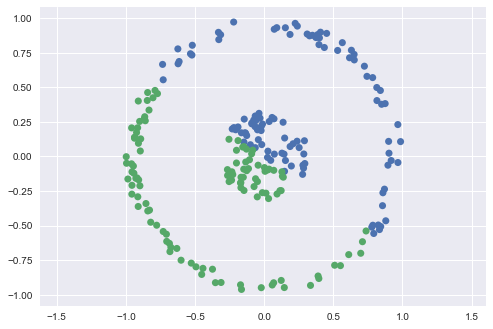

In [40]:

mat = scipy.io.loadmat('hw5_p1b.mat') # TODO : use right dataset
X = mat['X']

X2, y = make_classification(
            n_samples=10,
            n_features=2,
            n_redundant=0,
            n_repeated=0,
            n_classes=2,
            flip_y=0.1,
            #class_sep=0.001,
            n_clusters_per_class=1)
            #weights=[w])

##

k = 2
cluster = kernel_kmeans(X, k, kernel=rbf_kernel(2))

for c in range(k):
    z = cluster == c
    plt.scatter(X[z,0], X[z,1], marker='o', edgecolors='none', s=50, alpha=1.0)

plt.axis('equal')
plt.show()
